# Training a model with a curated image dataset in fastai
Walkthrough of how to train a deep learning model in fastai with a curated image dataset


In [82]:
# imports for notebook boilerplate
!pip install -Uqq fastbook
import fastbook
from fastbook import *
from fastai.vision.all import *

In [83]:
# set up the notebook for fast.ai
fastbook.setup_book()

# Ingest the dataset
- create a path object
- defined an ImageDataLoaders object

In [84]:
# ingest the curated image dataset CIFAR
path = untar_data(URLs.CIFAR)

In [85]:
path

Path('/storage/data/cifar10')

In [86]:
# examine the directory structure of the dataset
path.ls()

(#3) [Path('/storage/data/cifar10/train'),Path('/storage/data/cifar10/labels.txt'),Path('/storage/data/cifar10/test')]

In [87]:
'''pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
'''
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=parent_label)

In [88]:
dls = db.dataloaders(path/'train',bs=32)

In [89]:
# dls = db.dataloaders(path,bs=32)
#dls = ImageDataLoaders.from_folder(path, train='train', valid='test')

In [90]:
# summary must be run on DataBlock object, not dataloaders object
db.summary(path/"train")



Setting-up type transforms pipelines
Found 50000 items
2 datasets of sizes 40000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying parent_label gives
      truck
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(9))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Building one batch
Applying item_tfms to the firs

# Examine the dataset

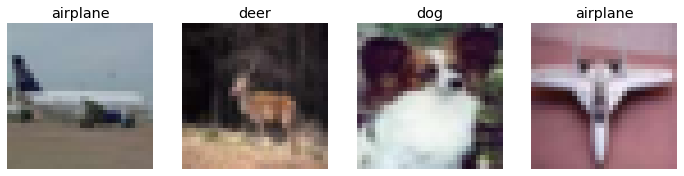

In [91]:
# show a batch of training data
dls.train.show_batch(max_n=4, nrows=1)


In [92]:
# examine the train subdirectory
(path/'train').ls()

(#10) [Path('/storage/data/cifar10/train/horse'),Path('/storage/data/cifar10/train/dog'),Path('/storage/data/cifar10/train/ship'),Path('/storage/data/cifar10/train/frog'),Path('/storage/data/cifar10/train/truck'),Path('/storage/data/cifar10/train/deer'),Path('/storage/data/cifar10/train/airplane'),Path('/storage/data/cifar10/train/automobile'),Path('/storage/data/cifar10/train/cat'),Path('/storage/data/cifar10/train/bird')]

In [93]:
(path/'train/dog').ls()

(#5000) [Path('/storage/data/cifar10/train/dog/26785_dog.png'),Path('/storage/data/cifar10/train/dog/47662_dog.png'),Path('/storage/data/cifar10/train/dog/48730_dog.png'),Path('/storage/data/cifar10/train/dog/40889_dog.png'),Path('/storage/data/cifar10/train/dog/24363_dog.png'),Path('/storage/data/cifar10/train/dog/44046_dog.png'),Path('/storage/data/cifar10/train/dog/26962_dog.png'),Path('/storage/data/cifar10/train/dog/19003_dog.png'),Path('/storage/data/cifar10/train/dog/47416_dog.png'),Path('/storage/data/cifar10/train/dog/31111_dog.png')...]

In [94]:
(path/'train/cat').ls()

(#5000) [Path('/storage/data/cifar10/train/cat/1845_cat.png'),Path('/storage/data/cifar10/train/cat/26087_cat.png'),Path('/storage/data/cifar10/train/cat/24817_cat.png'),Path('/storage/data/cifar10/train/cat/47541_cat.png'),Path('/storage/data/cifar10/train/cat/44852_cat.png'),Path('/storage/data/cifar10/train/cat/37669_cat.png'),Path('/storage/data/cifar10/train/cat/11236_cat.png'),Path('/storage/data/cifar10/train/cat/4329_cat.png'),Path('/storage/data/cifar10/train/cat/44859_cat.png'),Path('/storage/data/cifar10/train/cat/22425_cat.png')...]

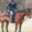

In [95]:
# take a look at one of the images
img_files = get_image_files(path)
img = PILImage.create(img_files[100])
img

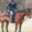

In [96]:
# display a thumbnail of the image
img.to_thumb(180)

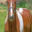

In [97]:
img = PILImage.create(img_files[3000])
img

# Define and train the model

In [100]:
#learn = cnn_learner(dls, resnet18, pretrained=False,
#                    loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn = cnn_learner(dls, resnet18, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=accuracy)

In [101]:
%%time
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.841837,1.751750,0.438600,01:24


epoch,train_loss,valid_loss,accuracy,time
0,1.270280,1.171861,0.707400,01:45
1,1.102574,1.063647,0.753400,01:45


CPU times: user 4min 46s, sys: 4.28 s, total: 4min 51s
Wall time: 4min 56s


In [58]:
learn.summary()

Sequential (Input shape: ['32 x 3 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 16 x 16    9,408      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 16 x 16    128        True      
________________________________________________________________
ReLU                 32 x 64 x 16 x 16    0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 8 x 8      0          False     
________________________________________________________________
Conv2d               32 x 64 x 8 x 8      36,864     True      
________________________________________________________________
BatchNorm2d          32 x 64 x 8 x 8      128        True      
________________________________________________________________
ReLU                 32 x 64 x 8 x 8      0          False     
___________________________________________________

# Try augmenting the training set

In [59]:
# create a new DataBlock object incorporating augmentation transformations
db2 = db.new(batch_tfms=aug_transforms())
# create a new dataloaders object based on the new DataBlock object
dls2 = db2.dataloaders(path/'train',bs=32)


In [60]:
db2.summary(path/"train")

Setting-up type transforms pipelines
Found 50000 items
2 datasets of sizes 40000,10000
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying PILBase.create gives
      PILImage mode=RGB size=32x32
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /storage/data/cifar10/train/truck/3702_truck.png
    applying parent_label gives
      truck
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(9)

Final sample: (PILImage mode=RGB size=32x32, TensorCategory(9))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Flip -- {'size': None, 'mode': 'bilinear', 'pad

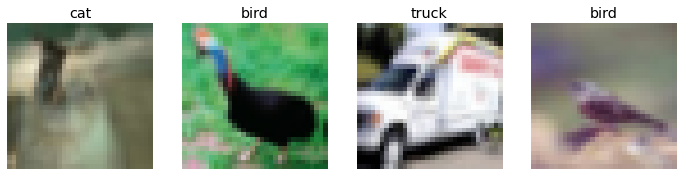

In [61]:
# examine a batch of the augmented training data
dls2.train.show_batch(max_n=4, nrows=1)

In [62]:
# define a distinct model based on the augmented dataloaders object
learn2 = cnn_learner(dls2, resnet18, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=accuracy)

In [63]:
%%time
learn2.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,1.896246,1.729444,0.449900,01:41


epoch,train_loss,valid_loss,accuracy,time
0,1.340509,1.230048,0.684300,02:01
1,1.218650,1.107695,0.729200,02:01


CPU times: user 5min 33s, sys: 5.8 s, total: 5min 39s
Wall time: 5min 44s


In [38]:
learn2.summary()

Sequential (Input shape: ['32 x 3 x 32 x 32'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               32 x 64 x 16 x 16    9,408      True      
________________________________________________________________
BatchNorm2d          32 x 64 x 16 x 16    128        True      
________________________________________________________________
ReLU                 32 x 64 x 16 x 16    0          False     
________________________________________________________________
MaxPool2d            32 x 64 x 8 x 8      0          False     
________________________________________________________________
Conv2d               32 x 64 x 8 x 8      36,864     True      
________________________________________________________________
BatchNorm2d          32 x 64 x 8 x 8      128        True      
________________________________________________________________
ReLU                 32 x 64 x 8 x 8      0          False     
___________________________________________________

# Examine the performance of the model


In [102]:
learn.validate()

(#2) [1.0636467933654785,0.7534000277519226]

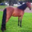

In [65]:
# take a look at one of the test images
img_test_files = get_image_files(path/"test")
img2 = PILImage.create(img_test_files[700])
img2

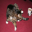

In [66]:
# select an image from the test set
img3 = PILImage.create(img_test_files[8000])
img3

In [67]:
# apply the trained model to the image
learn.predict(img2)

('horse',
 TensorImage(7),
 TensorImage([0.0064, 0.0135, 0.0128, 0.0046, 0.0067, 0.0118, 0.0060, 0.9214, 0.0076, 0.0091]))

In [68]:
# apply the trained model to the image
learn.predict(img3)

('dog',
 TensorImage(5),
 TensorImage([0.0141, 0.0101, 0.0068, 0.1967, 0.0080, 0.7306, 0.0137, 0.0115, 0.0029, 0.0057]))

In [69]:
learn.path = Path('/notebooks/temp/models')
learn.export('cifar_jun5_2021.pkl')
learn.save('cifar_save_jun6_2021')

Path('/notebooks/temp/models/models/cifar_save_jun6_2021.pth')

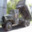

In [70]:
# select an image from the test set
img4 = PILImage.create(img_test_files[4000])
img4

In [71]:
learn.predict(img4)

('truck',
 TensorImage(9),
 TensorImage([0.0138, 0.0402, 0.0239, 0.2418, 0.0394, 0.0342, 0.0528, 0.0289, 0.0276, 0.4974]))

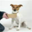

In [72]:
# take a look at a dog image from the training dataset
dog_files = get_image_files(path/"train/dog")
dog_img = PILImage.create(dog_files[30])
dog_img

In [74]:
learn.predict(dog_img)

('dog',
 TensorImage(5),
 TensorImage([0.0360, 0.0146, 0.0482, 0.3406, 0.0461, 0.4360, 0.0264, 0.0235, 0.0130, 0.0156]))

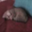

In [73]:
# take a look at a cat image from the training dataset
cat_files = get_image_files(path/"train/cat")
cat_img = PILImage.create(cat_files[30])
cat_img

In [75]:
learn.predict(cat_img)

('cat',
 TensorImage(3),
 TensorImage([0.0131, 0.0044, 0.0222, 0.7230, 0.0112, 0.1477, 0.0121, 0.0415, 0.0045, 0.0202]))

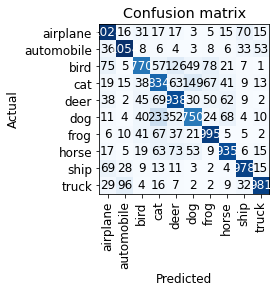

In [36]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

# Examine the performance of the model on the test set

In [76]:
# define a dataloader object on the test dataset
dls_test = db.dataloaders(path/'test',bs=32)

In [77]:
# define a learner that uses the dataloader object defined on the test dataset
learn_test = cnn_learner(dls_test, resnet18, 
                    loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=accuracy)

In [78]:
# point the model's path to where the weights were saved and load the weights
learn_test.path = Path('/notebooks/temp/models')
learn_test.load('cifar_save_jun6_2021')

In [79]:
learn_test.validate()

(#2) [1.043265461921692,0.7565000057220459]

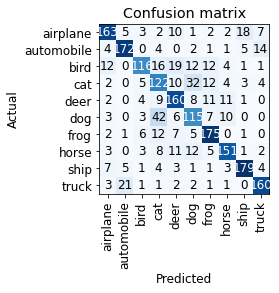

In [103]:
# show confusion matrix for the test dataset
interp_test = ClassificationInterpretation.from_learner(learn_test)
interp_test.plot_confusion_matrix()